# ***Exploring Visual Concept Learning with Deep Belief Networks on FashionMNIST***

#### Student: Dejan Dichoski (2071886)

In this project, we aim to investigate the process of visual concept learning with DBNs using simulations and analyses on FashionMNIST dataset. Visual concept learning is the process of acquiring knowledge about the visual features associated with different categories of objects. To do this, we will perform different tasks, specifically:

*   Analyze internal representations using hierarchical clustering (dendograms) and feature visualization methods (receptive fields). 
*   Use linear read-outs to test the model's representations at different levels of the hierarchy.
*   Visualize confusion matrices and psychometric curves to examine the model's performance under varying noise levels.
*   Evaluate the model's robustness against adversarial attacks.

Finally, we will discuss the details of our implementation, the motives behind our choices, and critically evaluate our results.

## Initial setup

Download a module for DBN implementation, import all the needed libraries and download the dataset (FashionMNIST).

In [ ]:
def get_dbn_library():
  files = ["DBN.py", "RBM.py"]
  repository_url = "https://raw.githubusercontent.com/flavio2018/Deep-Belief-Network-pytorch/master/"
  for file in files:
    !wget -O {file} {repository_url}{file}

In [ ]:
%%capture
get_dbn_library()

In [ ]:
# Imports
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import sklearn.preprocessing
import torch
import shutil
import scipy.cluster as cluster
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from DBN import DBN
from tqdm.notebook import tqdm
from torch.nn import functional
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
# Remove a file from google colab
try:
  shutil.rmtree('/content/data')
except:
  print("Folder doesn't exist.")

Let's choose dynamically the kind of device used for computations (CPU or GPU).

In [ ]:
print(torch.cuda.is_available())
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

True
cuda


[Fashion-MNIST](https://https://www.tensorflow.org/datasets/catalog/fashion_mnist#:~:text=Fashion%2DMNIST%20is%20a%20dataset,a%20label%20from%2010%20classes.&text=Versions%3A,3.0.) is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. To download the dataset using PyTorch, we can use the [torchvision.datasets](https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html) module. This returns a tuple (image, target), where image is the input image and target is the index of the corresponding output class. The dataset is already pre-separated into train and test sets. We can obtain the desired split, by setting the hyperparameter train to True/False.

In [ ]:
train_set = FashionMNIST("./data",
                        download=True,
                        transform=transforms.Compose( [transforms.ToTensor() ])
                        )
test_set = FashionMNIST("./data",
                        download=True,
                        train=False,
                        transform=transforms.Compose( [transforms.ToTensor()] )
                        ) 
# returns type torchvision.datasets.mnist.FashionMNIST 

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
X_train_tensor = train_set.data
y_train_tensor = train_set.targets
X_test_tensor  = test_set.data
y_test_tensor  = test_set.targets
print('Type: ', type(X_train_tensor)) # type torch.Tensor
print('Shape:\nTrain:',
      list(X_train_tensor.shape),
      list(y_train_tensor.shape),
      '\nTest: ',
      list(X_test_tensor.shape),
      list(y_test_tensor.shape))

Type:  <class 'torch.Tensor'>
Shape:
Train: [60000, 28, 28] [60000] 
Test:  [10000, 28, 28] [10000]


**Data normalization**

By normalizing our inputs to the range [0, 1], we're allowing the network to learn more quickly the optimal parameters. Also, this prevents some features from dominating others during the learning process. 

In [ ]:
print("Before normalization:\n",
      X_train_tensor.dtype, '\n',
      X_train_tensor.min().item(), X_train_tensor.max().item(), '\n',
      X_train_tensor.float().mean().item())
X_train_tensor = (X_train_tensor/255.0)
X_test_tensor = (X_test_tensor/255.0)
print("After normalization:\n",
      X_train_tensor.dtype, '\n',
      X_train_tensor.min().item(), X_train_tensor.max().item(), '\n',
      X_train_tensor.mean().item())

Before normalization:
 torch.uint8 
 0 255 
 72.94035339355469
After normalization:
 torch.float32 
 0.0 1.0 
 0.2860405743122101


## Data visualization

Let's do some exploratory data analysis (EDA), to get to know the dataset better.

In the following cells we'll display some statistical summaries, as well as plot examples from each class to gain insiguts into the distribution of the data.



In [ ]:
X_train_array = X_train_tensor.numpy().reshape(-1, X_train_tensor.shape[1] * X_train_tensor.shape[2])
y_train_array = y_train_tensor.numpy()[:, np.newaxis]
train_array   = np.hstack((X_train_array, y_train_array))
print(X_train_array.shape, y_train_array.shape)
print(train_array.shape)

(60000, 784) (60000, 1)
(60000, 785)


In [ ]:
train_df = pd.DataFrame(train_array)
train_df.iloc[:,-1] = train_df.iloc[:,-1].astype(int)
train_df.head()
# train_df.describe() # Mostly useless here

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,9
1,0.0,0.0,0.0,0.0,0.0,0.003922,0.0,0.0,0.000000,0.000000,...,0.447059,0.509804,0.298039,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.086275,...,0.000000,0.003922,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.129412,0.376471,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,3
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0


Class distribution

In [ ]:
train_df.iloc[:, -1].value_counts().sort_index()
# Equal number of examples per class (6000)

0    6000
1    6000
2    6000
3    6000
4    6000
5    6000
6    6000
7    6000
8    6000
9    6000
Name: 784, dtype: int64

Checking for null values:

In [ ]:
print('Number of null values in training dataset:', sum(train_df.isnull().sum()))

Number of null values in training dataset: 0


Here we declare some functions that we will use to visualize the examples in our dataset.

In [ ]:
def get_article_from_label(label):
  fashion_dict = { 0: "T-shirt/Top",
                   1: "Trouser",
                   2: "Pullover",
                   3: "Dress",
                   4: "Coat", 
                   5: "Sandal", 
                   6: "Shirt",
                   7: "Sneaker",
                   8: "Bag",
                   9: "Ankle Boot"
                  }
  return fashion_dict[label]

def plot_image_by_row_number(df, row_number=0):
  row   = df.iloc[row_number, :-1].values
  label = df.iloc[row_number, -1]
  image = np.reshape(row, (28, 28))
  print(f'{label}: {get_article_from_label(label)}')
  plt.imshow(image, cmap='gray')
  plt.show()

def plot_random_image_of_specified_label(df, label=0):
  row   = df[df.iloc[:, -1] == label].sample().iloc[0, :-1]
  image = np.reshape(row.values, (28, 28))
  print(f'Row: {row.name}\n{label}: {get_article_from_label(label)}')
  plt.imshow(image, cmap='gray')
  plt.show()

def get_random_image_of_specified_label(df, label=0):
  row   = df[df.iloc[:, -1] == label].sample().iloc[0, :-1]
  image = np.reshape(row.values, (28, 28))
  return image 

8: Bag


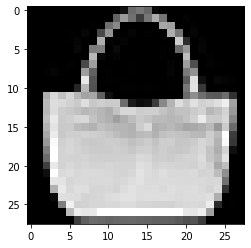

In [ ]:
plot_image_by_row_number(train_df, 100)

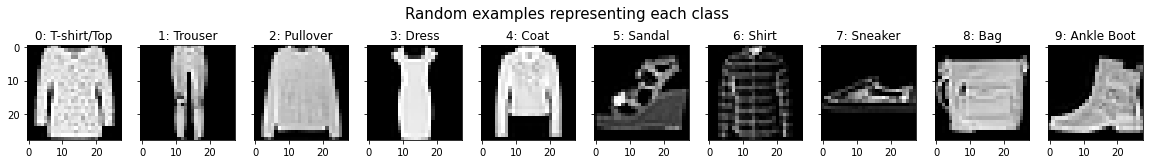

In [ ]:
fig, ax = plt.subplots(1, 10, sharex=True, sharey=True, figsize=(20, 2))
fig.suptitle('Random examples representing each class', fontsize=15, y=1.1)
for i in range(10):
  image = get_random_image_of_specified_label(train_df, i)
  ax[i].imshow(image, cmap='gray')
  ax[i].set_title(str(i) + ': ' + get_article_from_label(i))

## Deep Belief Network (DBN)

A [Deep Belief Network](https://github.com/AmanPriyanshu/Deep-Belief-Networks-in-PyTorch) (DBN) is a generative graphical model composed of multiple layers of latent variables (hidden units), with connections between the layers but not between units within each layer.

When trained on a set of examples without supervision, a DBN can probabilistically reconstruct its inputs and learn to detect features. After this unsupervised learning step, a DBN can be further trained with supervision to perform classification.

Specifically, DBNs can be viewed as a composition of simple, unsupervised networks such as **Restricted Boltzmann Machines (RBMs)** or autoencoders, where each sub-network's hidden layer serves as the visible layer for the next. This composition leads to a fast, layer-by-layer unsupervised training procedure, where **Contrastive Divergence (CD)** is applied to each sub-network in turn, starting from the "lowest" pair of layers (the training set).

In [ ]:
hidden_units_list = [200, 300, 500]                               # try [200, 400, 800], [100, 100, 400], [200, 200, 400]
dbn_fashionmnist  = DBN( visible_units       = 28*28,
                         hidden_units        = hidden_units_list, # number of neurons in the hidden layers
                         k                   = 1,                 # n_gibbs_sampling_steps
                         learning_rate       = 0.05,              # try 0.01, 0.1             
                         learning_rate_decay = False,
                         initial_momentum    = 0.5,               # to speed up convergence of the gradient descent
                         final_momentum      = 0.95,   
                         weight_decay        = 0.0001,            # L2 regularization (to prevent overfitting)
                         xavier_init         = False,             # weight initialization
                         increase_to_cd_k    = False,
                         use_gpu             = torch.cuda.is_available()
                        )

***k*** is a hyperparameter that determines the number of Gibbs sampling steps to be used in the [Contrastive Divergence](https://https://www.youtube.com/watch?v=UcAWwySuUZM&t=502s) (CD) algorithm during the pretraining phase of the DBN. CD is an algorithm for approximating the maximum likelihood estimate of the parameters in RBM, which is a building block in the DBN.

In CD-k, the algorithm involves running k steps of Gibbs sampling to compute the positive and negative phases of the CD algorithm. The goal of CD is to find a set of weights that minimize the difference between the empirical data distribution and the model distribution. By increasing the number of Gibbs sampling steps, the model can capture higher-order dependencies in the data, but the computation time also increases.

When k=1, this corresponds to the CD-1 algorithm, which is the most commonly used variant of CD. In CD-1, the weights are updated based on the difference between the data distribution and the model distribution after a single step of Gibbs sampling.

In [ ]:
# Push onto GPU (if available)
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_test_tensor  = X_test_tensor.to(device)
y_test_tensor  = y_test_tensor.to(device)
print(device)

cuda


Let's train the DBN:

In [ ]:
num_epochs = 100 # Try 50, 100, 200, 300
batch_size = 100 # Try 125, 100, 75, 50

dbn_fashionmnist.train_static(X_train_tensor,
                              y_train_tensor,
                              num_epochs,
                              batch_size
                              )

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.5807     |0.0786       |143.5642   |3.5086     |
|20    |1.5128     |0.0764       |136.8009   |3.0379     |
|30    |1.4858     |0.0764       |132.6520   |2.3186     |
|40    |1.4726     |0.0757       |131.4158   |2.9568     |
|50    |1.4613     |0.0767       |128.4953   |3.0323     |
|60    |1.4566     |0.0758       |128.1633   |2.9737     |
|70    |1.4554     |0.0751       |128.2362   |3.0214     |
|80    |1.4514     |0.0750       |127.4719   |2.6367     |
|90    |1.4447     |0.0761       |126.1835   |3.2240     |
|100    |1.4403     |0.0755       |125.4778   |2.7016     |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.6471     |0.0594       |51.1317   |1.3052     |
|20    |1.5275     |0.0562       |47.9205   |1.2771     |
|30    |1.4928     |0.0547       |46.3012   |1.1483     |
|40    |1.4727     |0.0532       |4

---

**Analysis**

The reconstruction error on the entire training set should fall
rapidly and consistently at the start of learning and then more slowly. However, we follow the [advice](https://www.cs.toronto.edu/~hinton/absps/guideTR.pdf): 'Use it but don’t trust it', where 'it' refers to avg_rec_err.

---

## Visualizing receptive fields

The receptive field of a biological neuron is the portion of the sensory space that can elicit neuronal responses, when stimulated.

In the context of DL, the [Receptive Field](https://theaisummer.com/receptive-field/) is defined as the region of the input that produces a feature. This region can vary in size depending on the layers of the network, and it is a measure of the association of an output feature to the input region.

By visualizing the learned weights of the network, we can gain insights into which parts of an image correspond to the receptive fields of specific weight vectors, which can help us to understand how the network is processing the input.

Since the weights in the second and third hidden layers have different dimensions than the input images, we will need to project them onto a space of dimensionality 784 (28x28) in order to visualize them.

In [ ]:
def get_weights(dbn, layer):
  return dbn.rbm_layers[layer].W.cpu().numpy()

def apply_threshold(weights, threshold=0):
  return weights * (abs(weights) > threshold)

def apply_min_max_scaler(learned_weights):
  original_shape = learned_weights.shape
  min_max_scaler = sklearn.preprocessing.MinMaxScaler()
  min_max_scaled_learned_weights = min_max_scaler.fit_transform(learned_weights.ravel().reshape(-1,1))
  min_max_scaled_learned_weights = min_max_scaled_learned_weights.reshape(original_shape)
  return min_max_scaled_learned_weights
  
def plot_layer_receptive_fields(weights, layer):
  num_subplots = 100 # 7x7
  n_rows_cols = int(math.sqrt(num_subplots))
  fig, axes = plt.subplots(n_rows_cols, n_rows_cols, sharex=True, sharey=True, figsize=(10, 10))
  fig.suptitle('Receptive fields of layer ' + str(layer), fontsize=25, y=0.95)
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[row, col].imshow(weights[i,:].reshape((28,28)), cmap=plt.cm.gray)  # here we select the weights we want to plot  

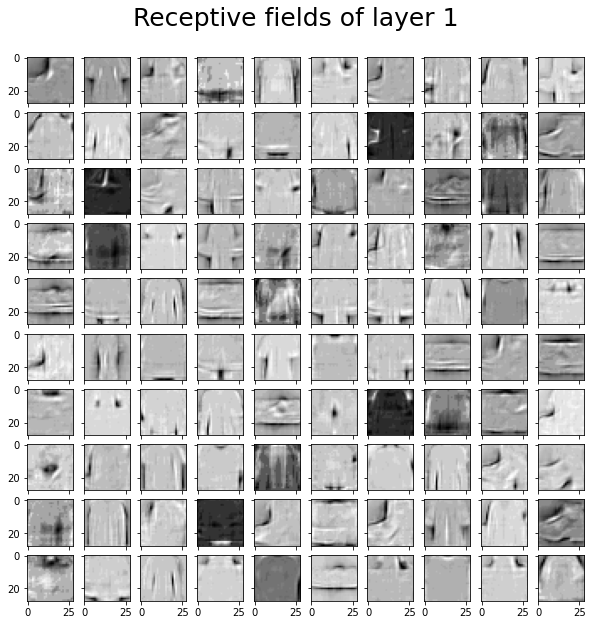

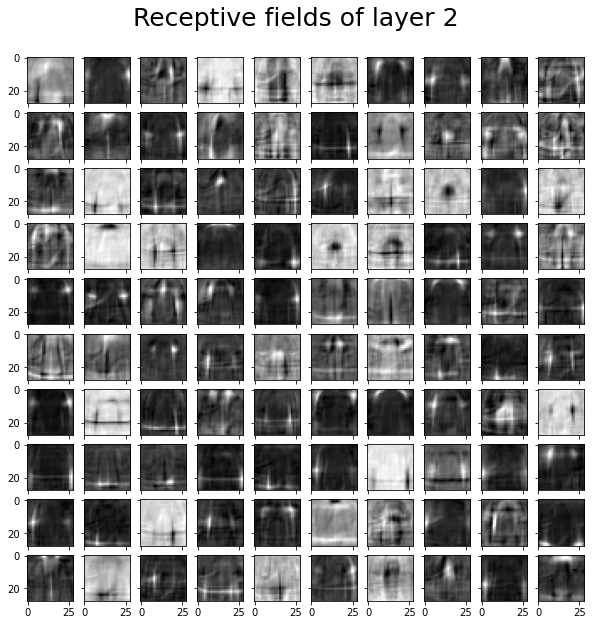

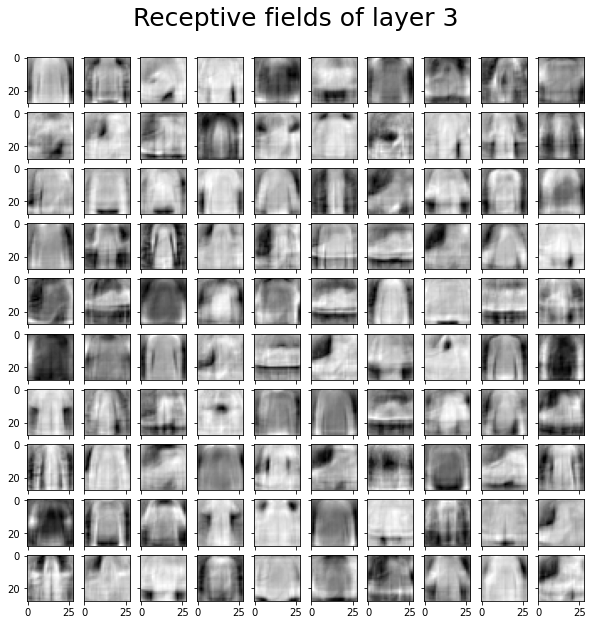

In [ ]:
learned_weights_layer_1    = get_weights(dbn_fashionmnist, layer=0)
learned_weights_layer_2    = get_weights(dbn_fashionmnist, layer=1)
learned_weights_layer_3    = get_weights(dbn_fashionmnist, layer=2)

# Here we do the projection (dot product)
learned_weights_12_product = (learned_weights_layer_1    @ learned_weights_layer_2)  
learned_weights_23_product = (learned_weights_12_product @ learned_weights_layer_3)

learned_weights_layer_1    = apply_threshold(learned_weights_layer_1, 0.1)
learned_weights_12_product = apply_threshold(learned_weights_12_product, 0.1)
learned_weights_23_product = apply_threshold(learned_weights_23_product, 0.1)

learned_weights_layer_1    = apply_min_max_scaler(learned_weights_layer_1)
learned_weights_12_product = apply_min_max_scaler(learned_weights_12_product)
learned_weights_23_product = apply_min_max_scaler(learned_weights_23_product)

learned_weights            = [ learned_weights_layer_1,
                               learned_weights_12_product,
                               learned_weights_23_product ]

for layer, weights in enumerate(learned_weights):
  plot_layer_receptive_fields(weights.T, layer+1)

---

**Analysis**

After visualizing the receptive fields for each layer of the DBN trained on FashionMNIST dataset, we can infer the following:
- The first layer appears to capture low-level features, such as edges and texture, and the receptive fields look like images with a high-pass filter applied.
- The receptive fields of the third layer contain higher-level features (more detailed), such as patterns and shapes.

---



## Clustering internal representations

Let's explore the learned representations of our pre-trained DBN on the FashionMNIST dataset. The idea is to see if the learned representations can capture **meaningful patterns** and **distinguish between different classes** of clothing items.

To do this, we first extract the hidden representations of the DBN for each image in the training set. Then, we compute the mean of the hidden representations for each class of a clothing article, resulting in a set of **centroids** for each class. 

By running a clustering algorithm on the matrix containing all the centroids, we can visualize the output in a **dendrogram** plot to examine if there is any meaningful structure or patterns in the learned representations.

In [ ]:
def get_kth_layer_repr(input, k, device):
  flattened_input = input.view((input.shape[0], -1)).type(torch.FloatTensor).to(device)
  hidden_repr, __ = dbn_fashionmnist.rbm_layers[k].to_hidden(flattened_input)  # here we access the RBM object
  return hidden_repr

def get_mask(label):  # we use this function to filter by class
  labels = y_train_tensor.cpu().numpy()
  return labels == label

def get_label_to_mean_hidd_repr(hidden_representation):
  hidden_representation_np = hidden_representation.cpu().numpy()
  return {
    label: hidden_representation_np[get_mask(label)].mean(axis=0)  # here we filter by class and compute the mean
    for label in range(len(set(y_train_tensor.cpu().numpy())))
  }

def get_hidden_reprs_matrix(hidden_representation):  # we use this to build the matrices
  label_to_mean_hidd_repr = get_label_to_mean_hidd_repr(hidden_representation)
  return np.concatenate(
    [np.expand_dims(label_to_mean_hidd_repr[label], axis=0)  # here we adjust the shape of centroids to do the concat
    for label in range(len(set(y_train_tensor.cpu().numpy())))])

def plot_dendrogram(mean_repr_matrix, title=""):
  fig, ax    = plt.subplots(figsize=(12,6))
  linkage    = cluster.hierarchy.linkage(mean_repr_matrix, method="complete")  # we run the clustering algorithm here
  dendrogram = cluster.hierarchy.dendrogram(linkage)
  ax.set_title(title)
  
  x_tick_labels     = ax.get_xticklabels()                               # Get the x-axis tick labels
  x_ticks           = [int(label.get_text()) for label in x_tick_labels] # Extract the text of each tick label
  new_x_tick_labels = [get_article_from_label(i) for i in x_ticks]       # Change the x-axis tick labels
  ax.set_xticklabels(new_x_tick_labels)

(10, 200) (10, 300) (10, 500) 



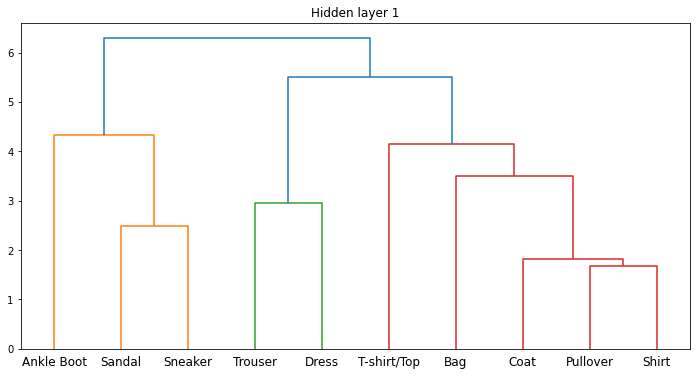

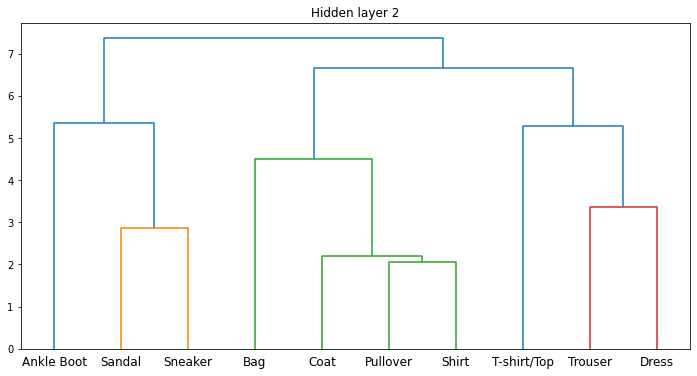

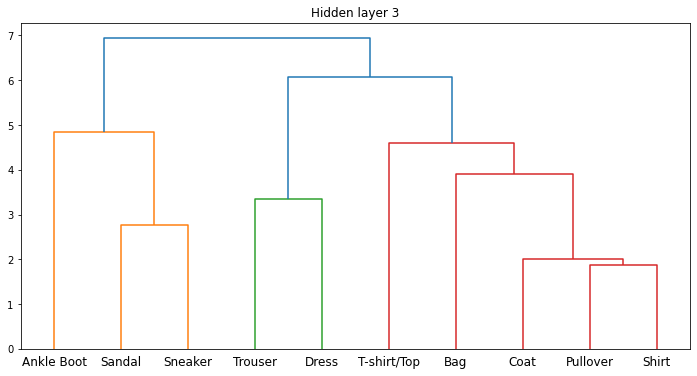

In [ ]:
hidden_repr_layer_1 = get_kth_layer_repr(X_train_tensor, 0, device)
hidden_repr_layer_2 = get_kth_layer_repr(hidden_repr_layer_1, 1, device)
hidden_repr_layer_3 = get_kth_layer_repr(hidden_repr_layer_2, 2, device)

mean_hidd_repr_matrix_1 = get_hidden_reprs_matrix(hidden_repr_layer_1)
mean_hidd_repr_matrix_2 = get_hidden_reprs_matrix(hidden_repr_layer_2)
mean_hidd_repr_matrix_3 = get_hidden_reprs_matrix(hidden_repr_layer_3)

print(mean_hidd_repr_matrix_1.shape, mean_hidd_repr_matrix_2.shape, mean_hidd_repr_matrix_3.shape, '\n')

mean_hidd_repr_matrices = [ mean_hidd_repr_matrix_1,
                            mean_hidd_repr_matrix_2,
                            mean_hidd_repr_matrix_3 ]
                            
for idx, mean_hidd_repr_matrix in enumerate(mean_hidd_repr_matrices):
  plot_dendrogram(mean_hidd_repr_matrix, f"Hidden layer {idx+1}")

---

**Analysis**

According to theory, as we go deeper through the network, we learn more meaningfull representations, leading to more efficient clustering. By focusing on the dendrogram of the third layer, we can identify which classes are the most similar, for example 'Pullover' and 'Shirt', since they are connected but also have the smallest Euclidean distance. Here, it's important to mention that the y-axis represents the distance between clusters. As the differences between classes increase, so does the distance, so we can see 'Ankle Boot' and 'Shirt' as two very different classes.

However, to further test the theoretical claim made in the first sentence, we will perform supervised learning using the learned features of each layer and evaluate the performance of the resulting classifiers. This will give us a better understanding of the quality of the learned features in each layer.

---


## Linear read-out

To evaluate  the quality of the hidden representations computed by the DBN, we will conduct  linear readouts at each layer. We do this by attaching an output layer, that is fully connected to the previous layer, forming a linear pattern associator. We will then train it using supervised learning (back-propagation).

In [ ]:
class LinearModel(torch.nn.Module):
  def __init__(self, layer_size):
    super().__init__()
    self.linear = torch.nn.Linear(layer_size, 10)
  def forward(self, x):
    return self.linear(x)

def train_loss(network, input, epochs=1500):
  optimizer = torch.optim.SGD(network.parameters(), lr=0.05) # try 0.01, 0.05, 0.07
  loss_fn   = torch.nn.CrossEntropyLoss() # because it's multiclass
  loss_list = []
  for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = network(input).squeeze()
    targets     = y_train_tensor.reshape(predictions.shape[0])  # here are the labels
    loss        = loss_fn(predictions, targets)
    loss.backward() # backpropagate the gradient
    optimizer.step()
    loss_list.append(loss.item())
  return loss_list

def compute_accuracy(predictions_test, targets):
  predictions_indices = predictions_test.max(axis=1).indices  # convert probabilities to indices
  accuracy            = (predictions_indices == targets).sum() / len(targets)
  return accuracy.item()

Training the linear classifiers on the hidden representations obtained from each layer. The targets for these classifiers are the actual labels of the FashionMNIST dataset.

      loss_layer_1  loss_layer_2  loss_layer_3
0         2.377046      2.362407      2.269342
100       0.921836      0.804046      0.837246
200       0.731763      0.668318      0.675178
300       0.655248      0.610595      0.609815
400       0.611239      0.575740      0.572052
500       0.581514      0.551510      0.546520
600       0.559587      0.533353      0.527713
700       0.542500      0.519088      0.513097
800       0.528676      0.507502      0.501311
900       0.517183      0.497856      0.491543
1000      0.507427      0.489664      0.483276
1100      0.499008      0.482596      0.476159
1200      0.491642      0.476415      0.469946
1300      0.485127      0.470949      0.464460
1400      0.479307      0.466069      0.459567
1499      0.474117      0.461716      0.455208 



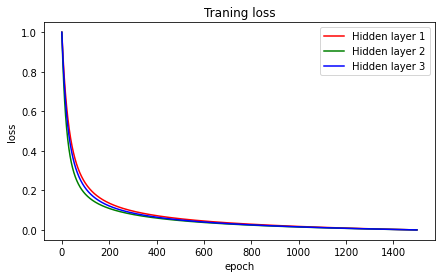

In [ ]:
linear1 = LinearModel(hidden_units_list[0]).to(device) # dbn_fashionmnist.rbm_layers[0].W.shape[1]
linear2 = LinearModel(hidden_units_list[1]).to(device)
linear3 = LinearModel(hidden_units_list[2]).to(device)

loss_layer_1 = train_loss(linear1, hidden_repr_layer_1)
loss_layer_2 = train_loss(linear2, hidden_repr_layer_2)
loss_layer_3 = train_loss(linear3, hidden_repr_layer_3)

df_losses = pd.DataFrame({'loss_layer_1': loss_layer_1, 'loss_layer_2': loss_layer_2, 'loss_layer_3': loss_layer_3})
print(df_losses[(df_losses.index % 100 == 0) | (df_losses.index == 1499)], '\n')

fig = plt.figure(figsize=(7, 4))
plt.plot(sklearn.preprocessing.MinMaxScaler().fit_transform(np.array(loss_layer_1).reshape(-1,1)), 'r', label='Hidden layer 1')
plt.plot(sklearn.preprocessing.MinMaxScaler().fit_transform(np.array(loss_layer_2).reshape(-1,1)), 'g', label='Hidden layer 2')
plt.plot(sklearn.preprocessing.MinMaxScaler().fit_transform(np.array(loss_layer_3).reshape(-1,1)), 'b', label='Hidden layer 3')
plt.legend()
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('Traning loss')
plt.show()

---

**Analysis**

After training a linear classifier on the hidden representations from each layer, we can see that the trainingloss decreases as we go deeper through the network.

---


We will now create representations of the FashionMNIST test set, and use them to see how well the trained linear readouts can classify the images. We'll measure the classification accuracy to evaluate their performance.

In [ ]:
hidden_repr_layer_1_test = get_kth_layer_repr(X_test_tensor, 0, device)
hidden_repr_layer_2_test = get_kth_layer_repr(hidden_repr_layer_1_test, 1, device)
hidden_repr_layer_3_test = get_kth_layer_repr(hidden_repr_layer_2_test, 2, device)

# here we compute the predictions
predictions_test1 = linear1(hidden_repr_layer_1_test)
predictions_test2 = linear2(hidden_repr_layer_2_test)
predictions_test3 = linear3(hidden_repr_layer_3_test)

print('Test set accuracy:')
print('Layer 1:', compute_accuracy(predictions_test1, y_test_tensor))
print('Layer 2:', compute_accuracy(predictions_test2, y_test_tensor))
print('Layer 3:', compute_accuracy(predictions_test3, y_test_tensor))

Test set accuracy:
Layer 1: 0.8262999653816223
Layer 2: 0.8271999955177307
Layer 3: 0.8301999568939209


---

**Analysis**

The test accuracy of the hidden representations also decreases as we go deeper throughout the network, with the hidden representations of the third layer showing the best performance (83% accuracy).

---

## Comparison with a feed-forward model

We will train a feed-forward NN with the same structure as the DBN to compare two different approaches for solving a classification task:
1.   A simple linear classifier that uses the input data's learned representations from the unsupervised DBN model.
2.   A non-linear model that is trained end-to-end.

In [ ]:
class Feedforward(torch.nn.Module):
  def __init__(self, first_hidden_layer_size, second_hidden_layer_size, third_hidden_layer_size):
    super().__init__()
    self.first_hidden  = torch.nn.Linear(784, first_hidden_layer_size) # Linear because we use RELU
    self.second_hidden = torch.nn.Linear(first_hidden_layer_size, second_hidden_layer_size)
    self.third_hidden  = torch.nn.Linear(second_hidden_layer_size, third_hidden_layer_size)
    self.output        = torch.nn.Linear(third_hidden_layer_size, 10) # there are 10 classes in FashionMNIST 

  def forward(self, input):
    relu               = torch.nn.ReLU()
    first_hidden_repr  = relu(self.first_hidden(input))
    second_hidden_repr = relu(self.second_hidden(first_hidden_repr))
    third_hidden_repr  = relu(self.third_hidden(second_hidden_repr))
    output             = self.output(third_hidden_repr)
    return output

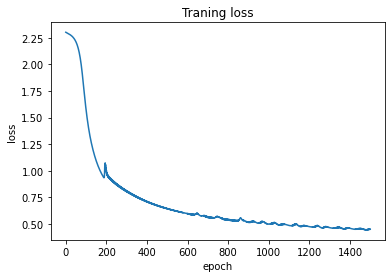


Test set accuracy for FFNN: 0.8281999826431274


In [ ]:
ffnn      = Feedforward(*hidden_units_list).to(device) # * is a spread operator
ffnn_loss = train_loss(ffnn, X_train_tensor.reshape((60000, 784)), epochs=1500)
plt.plot(ffnn_loss)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('Traning loss')
plt.show()

predictions_ffnn = ffnn(X_test_tensor.reshape((10000, 784)))
print('\nTest set accuracy for FFNN:', compute_accuracy(predictions_ffnn, y_test_tensor))

---

**Analysis**

The accuracy of the FFNN is similar (just a little bit lower) to that of the linear model trained on the representations of the third layer of the DBN: 82.8% vs 83%.

---

## Confusion matrices

A [confusion matrix](https://medium.com/analytics-vidhya/what-is-a-confusion-matrix-d1c0f8feda5) is an NxN matrix used for evaluating the performance of a classification model, where N is the number of target classes. The matrix compares the actual target values with those predicted by the ML model. For our case, we will generate a 10x10 matrix, because the FashionMNIST dataset has 10 output classes.

After generating the confusion matrix, it can be visualized with a heatmap created using the seaborn library. The cells in the heatmap are colored based on their values, ranging from white for low values to dark blue for high values.


In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=True, title=None, cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(15, 7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

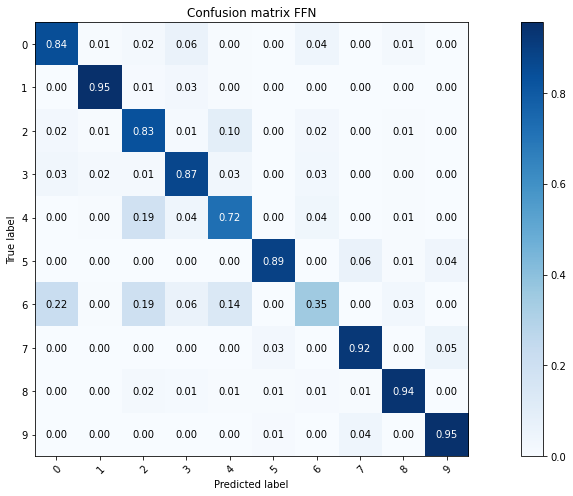

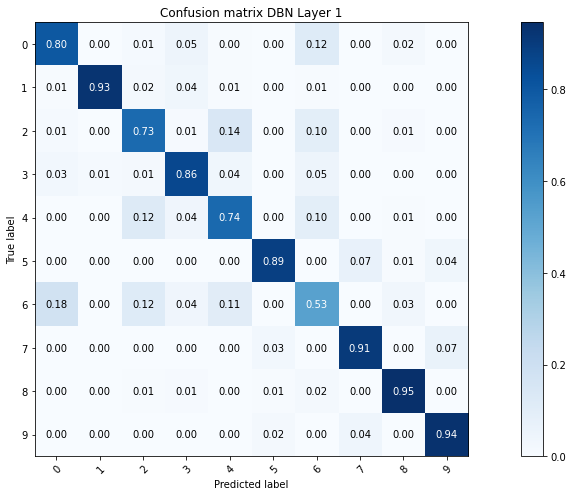

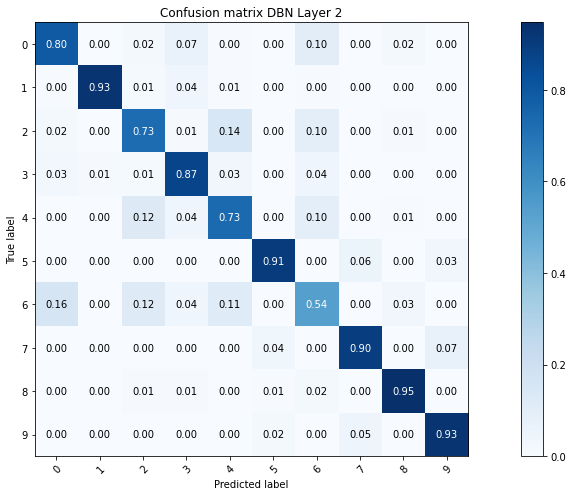

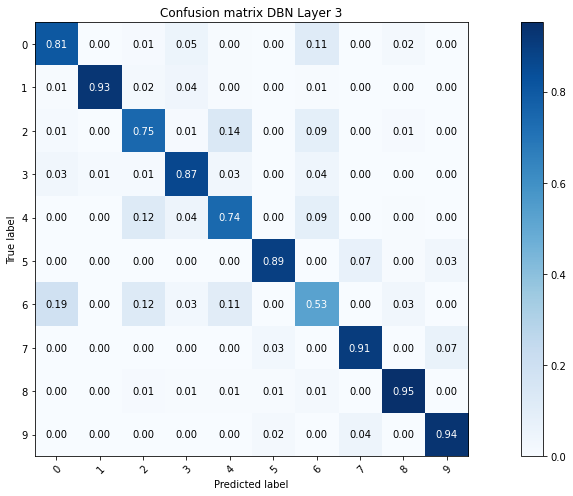

In [ ]:
classes = list(range(10))
y_true = y_test_tensor.cpu().numpy()

#confusion matrix for ffnn 
y_pred_ffn = predictions_ffnn.cpu().detach().max(axis=1).indices.numpy()
plot_confusion_matrix(y_true, y_pred_ffn, classes, title='Confusion matrix FFN')

#confusion matrix for the first layer of DBN
y_pred_1 = predictions_test1.cpu().detach().max(axis=1).indices.numpy()
plot_confusion_matrix(y_true, y_pred_1, classes, title='Confusion matrix DBN Layer 1')

#confusion matrix for the second layer of DBN
y_pred_2 = predictions_test2.cpu().detach().max(axis=1).indices.numpy()
plot_confusion_matrix(y_true, y_pred_2, classes, title='Confusion matrix DBN Layer 2')

#confusion matrix for the third layer of DBN
y_pred_3 = predictions_test3.cpu().detach().max(axis=1).indices.numpy()
plot_confusion_matrix(y_true, y_pred_3, classes, title='Confusion matrix DBN Layer 3')

plt.show()

---

**Analysis**

From the Confusion matrices, we can infer that all of our models (especially the FFNN) underperform at correctly classifying class 6 ('Shirt'). This could be due to its similarity to other classes, such as 0 ('T-shirt/Top'), 2 ('Pullover') and 4 ('Coat'). Additionally, in some cases, classes 2 ('Pullover') and 4 ('Coat') are misclassified as each other.

---

## Robustness to noise

In machine learning, [noise](https://www.diva-portal.org/smash/get/diva2:1597519/FULLTEXT01.pdf) refers to the random and unpredictable distortions or errors that can occur in data due to various factors, such as malfunctions, faulty equipment, or human error. The presence of noise in data can negatively impact the performance of the ML model, particularly in terms of classification accuracy. That's why, after computing the accuracy, we'll test the robustness of the models to noise. One way to measure a classifier's ability to handle noise is to inject noise (we'll use **Gaussian noise**) into the test set and compare the accuracy with and without noise, varying the amount of noise. We can visualize this using **psychometric curves**, which describe the decrease in classification accuracy with respect to the noise level.

In [ ]:
def inject_noise(data, noise_level): # simple function that adds some Gaussian noise to the data
  return data + ( noise_level * torch.randn_like(data) )

Let's visualize a perturbed image (with injected noise):

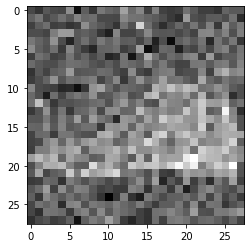

In [ ]:
noise_level = 0.3
fashion_mnist_test_with_noise = inject_noise(X_test_tensor, noise_level)
plt.imshow(fashion_mnist_test_with_noise[0].reshape(28, 28).to("cpu"), cmap="gray")
plt.show()

Let's evaluate the performance of the DBN on noisy images and compare it to the performance of the FFNN.

In [ ]:
def get_accuracy_values_at_noise_level(noise_level):

  fashion_mnist_test_with_noise   = inject_noise(X_test_tensor, noise_level)  # first, let's create noisy test images
  
  hidden_repr_layer_1_noisy       = get_kth_layer_repr(fashion_mnist_test_with_noise, 0, device)  # here we compute the DBN representations
  hidden_repr_layer_2_noisy       = get_kth_layer_repr(hidden_repr_layer_1_noisy,     1, device)
  hidden_repr_layer_3_noisy       = get_kth_layer_repr(hidden_repr_layer_2_noisy,     2, device)
  
  predictions_first_hidden_noisy  = linear1(hidden_repr_layer_1_noisy)  # here we use the previously-trained read-out classifiers
  predictions_second_hidden_noisy = linear2(hidden_repr_layer_2_noisy)
  predictions_third_hidden_noisy  = linear3(hidden_repr_layer_3_noisy)
  predictions_ffnn_noisy          = ffnn(fashion_mnist_test_with_noise.reshape((10000, 784)))

  accuracy_first_hidden           = compute_accuracy(predictions_first_hidden_noisy,  y_test_tensor.to(device))
  accuracy_second_hidden          = compute_accuracy(predictions_second_hidden_noisy, y_test_tensor.to(device))
  accuracy_third_hidden           = compute_accuracy(predictions_third_hidden_noisy,  y_test_tensor.to(device))
  accuracy_ffnn                   = compute_accuracy(predictions_ffnn_noisy, y_test_tensor.to(device)) # predictions_test, targets

  return accuracy_first_hidden, accuracy_second_hidden, accuracy_third_hidden, accuracy_ffnn

In [ ]:
acc = get_accuracy_values_at_noise_level(0.3);
print("Accuracy of H1 read-out: %.3f" % acc[0])
print("Accuracy of H2 read-out: %.3f" % acc[1])
print("Accuracy of H3 read-out: %.3f" % acc[2])
print("Accuracy of FF network : %.3f" % acc[3]) # much less tolerant to noise compared to DBN

Accuracy of H1 read-out: 0.789
Accuracy of H2 read-out: 0.807
Accuracy of H3 read-out: 0.809
Accuracy of FF network : 0.794


Let's create the psychometric curves for the DBN (at different levels of internal representations) and for the feed-forward network:

In [ ]:
def plot_noise_robustness_curves(noise_levels):
  accuracy_values_first_hidden  = []
  accuracy_values_second_hidden = []
  accuracy_values_third_hidden  = []
  accuracy_values_ffnn          = []

  for noise_level in noise_levels:
    acc = get_accuracy_values_at_noise_level(noise_level)
    accuracy_values_first_hidden.append(acc[0])
    accuracy_values_second_hidden.append(acc[1])
    accuracy_values_third_hidden.append(acc[2])
    accuracy_values_ffnn.append(acc[3])

  fig, ax = plt.subplots()
  ax.plot(range(len(noise_levels)), accuracy_values_first_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_second_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_third_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_ffnn)

  ax.set_title("Robustness to noise")
  ax.set_xlabel("Noise level (%)")
  ax.set_ylabel("Accuracy")
  plt.xticks(range(len(noise_levels)), [int(l*100) for l in noise_levels])
  plt.legend(["First hidden", "Second hidden", "Third hidden", "FFNN"])

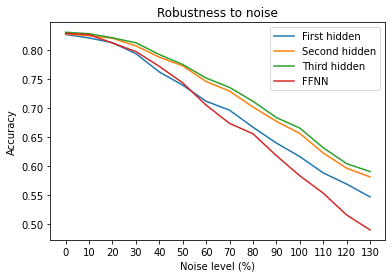

In [ ]:
noise_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3]
plot_noise_robustness_curves(noise_levels)

---

**Analysis**

We can observe that the DBN's representations outperform the FFNN model when dealing with noisy inputs. This is due to the power of DBNs to remove noise from images.

---

### Data augmentation

As an addition to testing the robustness to noise, let's also evaluate our models' performance when dealing with images that have increased contrast and affine transformations.

#### Contrast

In [ ]:
def adjust_contrast(dataset, contrast_factor=2):
  '''contrast_factor (float) – How much to adjust the contrast. Can be any non-negative number.
  0 gives a solid gray image, 1 gives the original image while 2 increases the contrast by a factor of 2'''
  adjusted_dataset = []
  for img in dataset:
    adjusted_img = transforms.functional.adjust_contrast(img.unsqueeze(0), contrast_factor)
    adjusted_dataset.append(adjusted_img)
  return torch.stack(adjusted_dataset)

def get_accuracy_values_with_contrast_factor(contrast_factor):

  adjusted_dataset                = adjust_contrast(X_test_tensor, contrast_factor)
  hidden_repr_layer_1_noisy       = get_kth_layer_repr(adjusted_dataset, 0, device)  # here we compute the DBN representations
  hidden_repr_layer_2_noisy       = get_kth_layer_repr(hidden_repr_layer_1_noisy,     1, device)
  hidden_repr_layer_3_noisy       = get_kth_layer_repr(hidden_repr_layer_2_noisy,     2, device)
  
  predictions_first_hidden_noisy  = linear1(hidden_repr_layer_1_noisy)  # here we use the previously-trained read-out classifiers
  predictions_second_hidden_noisy = linear2(hidden_repr_layer_2_noisy)
  predictions_third_hidden_noisy  = linear3(hidden_repr_layer_3_noisy)
  predictions_ffnn_noisy          = ffnn(adjusted_dataset.reshape((10000, 784)))

  accuracy_first_hidden           = compute_accuracy(predictions_first_hidden_noisy,  y_test_tensor.to(device))
  accuracy_second_hidden          = compute_accuracy(predictions_second_hidden_noisy, y_test_tensor.to(device))
  accuracy_third_hidden           = compute_accuracy(predictions_third_hidden_noisy,  y_test_tensor.to(device))
  accuracy_ffnn                   = compute_accuracy(predictions_ffnn_noisy, y_test_tensor.to(device)) # predictions_test, targets

  return accuracy_first_hidden, accuracy_second_hidden, accuracy_third_hidden, accuracy_ffnn
  
def plot_contrast_robustness_curves(contrast_factors):
  accuracy_values_first_hidden  = []
  accuracy_values_second_hidden = []
  accuracy_values_third_hidden  = []
  accuracy_values_ffnn          = []

  for contrast_factor in contrast_factors:
    acc = get_accuracy_values_with_contrast_factor(contrast_factor)
    accuracy_values_first_hidden.append(acc[0])
    accuracy_values_second_hidden.append(acc[1])
    accuracy_values_third_hidden.append(acc[2])
    accuracy_values_ffnn.append(acc[3])

  fig, ax = plt.subplots()
  ax.plot(range(len(contrast_factors)), accuracy_values_first_hidden)
  ax.plot(range(len(contrast_factors)), accuracy_values_second_hidden)
  ax.plot(range(len(contrast_factors)), accuracy_values_third_hidden)
  ax.plot(range(len(contrast_factors)), accuracy_values_ffnn)

  ax.set_title("Robustness to contrast modifications")
  ax.set_xlabel("Contrast factor")
  ax.set_ylabel("Accuracy")
  plt.xticks(range(len(contrast_factors)), [int(l) for l in contrast_factors])
  plt.legend(["First hidden", "Second hidden", "Third hidden", "FFNN"])

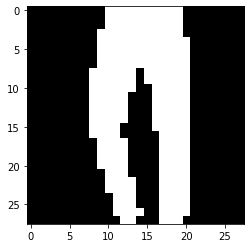

In [ ]:
adjusted_dataset = adjust_contrast(X_test_tensor, 1000)

plt.imshow(adjusted_dataset[5].squeeze().to("cpu"), cmap="gray") 
plt.show()

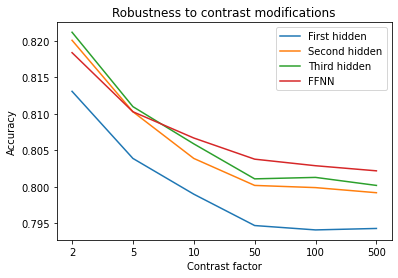

In [ ]:
contrast_factors = [2, 5, 10, 50, 100, 500]
plot_contrast_robustness_curves(contrast_factors)

---

**Analysis**

Overall, our models perform well when dealing with inputs that have modified contrast, exhibiting a maximum 3% drop in accuracy. The FFNN and the Third hidden layer of the DBN demonstrate the best accuracy among the models.

---

#### Affine transform

In [ ]:
def affine_transform(dataset):
  transformed_dataset = []
  transform = transforms.RandomAffine((50, 60))
  for img in dataset:
    img_affine = transform(img.unsqueeze(0))
    transformed_dataset.append(img_affine)
  return torch.stack(transformed_dataset)

def get_accuracy_values_with_affine():
  dataset_affine = affine_transform(X_test_tensor)
  
  hidden_repr_layer_1_noisy       = get_kth_layer_repr(dataset_affine, 0, device)  # here we compute the DBN representations
  hidden_repr_layer_2_noisy       = get_kth_layer_repr(hidden_repr_layer_1_noisy,     1, device)
  hidden_repr_layer_3_noisy       = get_kth_layer_repr(hidden_repr_layer_2_noisy,     2, device)
  
  predictions_first_hidden_noisy  = linear1(hidden_repr_layer_1_noisy)  # here we use the previously-trained read-out classifiers
  predictions_second_hidden_noisy = linear2(hidden_repr_layer_2_noisy)
  predictions_third_hidden_noisy  = linear3(hidden_repr_layer_3_noisy)
  predictions_ffnn_noisy          = ffnn(dataset_affine.reshape((10000, 784)))

  accuracy_first_hidden           = compute_accuracy(predictions_first_hidden_noisy,  y_test_tensor.to(device))
  accuracy_second_hidden          = compute_accuracy(predictions_second_hidden_noisy, y_test_tensor.to(device))
  accuracy_third_hidden           = compute_accuracy(predictions_third_hidden_noisy,  y_test_tensor.to(device))
  accuracy_ffnn                   = compute_accuracy(predictions_ffnn_noisy, y_test_tensor.to(device)) # predictions_test, targets

  return accuracy_first_hidden, accuracy_second_hidden, accuracy_third_hidden, accuracy_ffnn

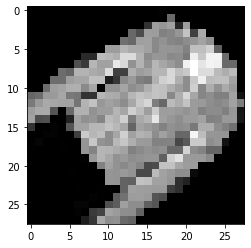

In [ ]:
dataset_affine = affine_transform(X_test_tensor)
plt.imshow(dataset_affine[10].squeeze().to("cpu"), cmap="gray")
plt.show()

In [ ]:
accuracy_first_hidden, accuracy_second_hidden, accuracy_third_hidden, accuracy_ffn = get_accuracy_values_with_affine()
print('Accuracy:',
      '\nHidden 1:', accuracy_first_hidden,
      '\nHidden 2:', accuracy_second_hidden,
      '\nHidden 3:', accuracy_third_hidden,
      '\nFFN:     ', accuracy_ffn)

Accuracy: 
Hidden 1: 0.0835999995470047 
Hidden 2: 0.08989999443292618 
Hidden 3: 0.08949999511241913 
FFN:      0.05819999799132347


---

**Analysis**

We can see that our models totally fail at making predictions on images that are geometrically transformed. The accuracy is even lower than chance level, i.e., 0.1. This can be improved by introducing affine transformed images in our training dataset.

---


## Perturbing the models with adversarial attacks

[Adversarial examples](https://www.tensorflow.org/tutorials/generative/adversarial_fgsm) are specialised inputs created with the purpose of confusing a neural network, resulting in misclassification of a given input. These notorious inputs are indistinguishable to the human eye, but cause the network to fail to identify the contents of the image.

There are several types of such attacks, however, here the focus is on the fast gradient sign method attack, which is a white box attack whose goal is to ensure misclassification. A white box attack is where the attacker has complete access to the model being attacked.

The **fast gradient sign method** ([FGSM](https://jaketae.github.io/study/fgsm/)) works by using the gradients of the neural network to create an adversarial example. For an input image, the method uses the gradients of the loss with respect to the input image to create a new image that maximises the loss. This new image is called the adversarial image. This can be summarised using the following expression:

$\tilde{x} = x + \epsilon \cdot \text{sign}(\nabla_{x} J(w, x, y))$,

where J represents the loss function and $\epsilon$ is a multiplier to ensure the perturbations are small.

In [ ]:
def fgsm_attack(image, epsilon, data_grad): # image is the input image, epsilon is the amount of noise (strenght of the attack), gradient of the data
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()

    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad # the equation above

    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    # Return the perturbed image
    return perturbed_image

class DBNWithReadOut(torch.nn.Module): # forward pass from the input to the output - input is propagated through the dbn, so later it can be backpropagated
    def __init__(self, dbn_mnist, readouts, readout_level=0):
        super().__init__()
        self.readouts = readouts
        self.dbn_mnist = dbn_mnist
        self._require_grad()
        self.readout_level = readout_level

    def _require_grad(self):
      for rbm in self.dbn_mnist.rbm_layers:
        rbm.W.requires_grad_()
        rbm.h_bias.requires_grad_()

    def forward(self, image):
      """This forward pass uses probabilities instead of samples as RBM outputs
       to backpropagate the gradient"""
      p_v = image
      hidden_states = []
      for rbm in self.dbn_mnist.rbm_layers:
        p_v = p_v.view((p_v.shape[0], -1))  # flatten
        p_v, v = rbm(p_v)
        hidden_states.append(p_v)
      return self.readouts[self.readout_level].forward(hidden_states[self.readout_level])

We will create and visualize an adversarial sample, compare it to the original sample, and then classify both samples using the models we previously trained.

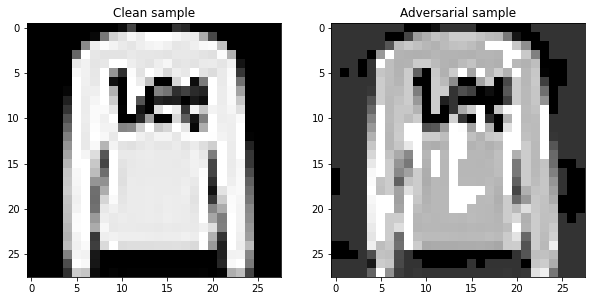


The prediction of the DBN for the clean sample is 2.
The prediction of the FFN for the clean sample is 2.

The prediction of the DBN for the adversarial sample is 2.
The prediction of the FFN for the adversarial sample is 2.


In [ ]:
# Test sample
test_sample_idx = 1
test_image = X_test_tensor[test_sample_idx].reshape(1, 784)

# Classify clean sample using DBN and FFB
test_image.requires_grad_()

attacked_model_ffn = ffnn
model_outputs_ffn  = attacked_model_ffn(test_image)
prediction_ffn     = torch.argmax(model_outputs_ffn)

dbn_with_readout   = DBNWithReadOut(dbn_fashionmnist, [linear1, linear2, linear3], readout_level=2) # previous DBN + the three hidden layers;
attacked_model_dbn = dbn_with_readout 
model_outputs_dbn  = attacked_model_dbn(test_image)
prediction_dbn     = torch.argmax(model_outputs_dbn)


## Adversarial attack on the network
epsilon            = 0.2 # define strength of the attack
test_image_label   = y_test_tensor[test_sample_idx].unsqueeze(0)  # get ground truth label for that image
loss_value         = torch.nn.functional.cross_entropy(model_outputs_dbn, test_image_label)  # get loss value
attacked_model_dbn.zero_grad()
loss_value.backward()
image_grad         = test_image.grad.data  # get the gradient of the pixels w.r.t. the loss

perturbed_image    = fgsm_attack(test_image, epsilon, image_grad) # image, epsilon, data_grad
perturbed_image_np = perturbed_image.detach().to('cpu').numpy()

# Plot Clean vs Adversarial sample
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axs[0].imshow(test_image.detach().reshape(28,28).to('cpu'), cmap='gray')
axs[0].set_title('Clean sample')
axs[1].imshow(perturbed_image_np.reshape(28,28), cmap='gray')
axs[1].set_title('Adversarial sample')
plt.show()

# Print the predictions of the DBN/FFN for clean/adversarial example
print(f"\nThe prediction of the DBN for the clean sample is {prediction_dbn}.")
print(f"The prediction of the FFN for the clean sample is {prediction_ffn}.\n")

model_outputs_dbn  = attacked_model_dbn(perturbed_image.view((perturbed_image.shape[0], -1)))
print(f"The prediction of the DBN for the adversarial sample is {torch.argmax(model_outputs_dbn)}.")
model_outputs_ffn  = attacked_model_ffn(perturbed_image.view((perturbed_image.shape[0], -1)))
print(f"The prediction of the FFN for the adversarial sample is {torch.argmax(model_outputs_ffn)}.")

---

**Analysis**

We can see that both the DBN and the FFNN are resisting the adversarial attack. However, they begin making incorrect predictions for higher values of epsilon.

---

Next, we will evaluate the resistance of our two models, the feedforward network and the DBN, against adversarial attacks. Additionally, we will examine the DBN's ability to mitigate the impact of the attack by implementing a "top-down" reconstruction step. This involves reconstructing the visible units from the hidden representation of the last layer, and then reconstructing the hidden representation.

In [ ]:
def test_robustness_to_attack(model, device, test_loader, epsilon, num_steps=0, verbose=True): # num_steps is the number of top-down reconstructions we do
    correct = 0
    print_reconstruction = num_steps > 0

    for data, target in tqdm(test_loader):
        data, target = data.to(device), target.to(device)
        data = data.reshape(-1, 784)
        data.requires_grad = True  # Important for Attack
        
        output = model.forward(data)

        init_pred = torch.argmax(output)
        
        if (print_reconstruction and verbose):
          print("\nHere's the original sample:\n")
          plt.imshow(data[0].detach().to('cpu').numpy().reshape(28,28), cmap='gray')
          plt.show()

        loss = functional.nll_loss(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data  # collect the gradient of the input data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        if (print_reconstruction and verbose):
            print("\nHere's a perturbed sample:\n")
            plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28), cmap='gray')
            plt.show()

        # If requested, reconstruct the input iterating forward-backward dynamics
        if num_steps > 0:
            for __ in range(0, num_steps):
                perturbed_data, __ = model.dbn_mnist.reconstruct(perturbed_data)
            if (print_reconstruction and verbose):
                print(f"\nHere's what a {num_steps}-steps reconstructed sample looks like:\n")
                plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28), cmap='gray')
                plt.show()
                print_reconstruction = False

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        # get the index of the max element in the output
        final_pred = output.max(1, keepdim=True)[1]
        final_pred = output.argmax(-1)
        correct += (final_pred == target).sum()

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader.sampler))
    print("\nEpsilon: {}\nTest Accuracy: {:.2f}%\n".format(epsilon, final_acc*100))

    return final_acc.item()

In [ ]:
test_loader = DataLoader(FashionMNIST('data/',
                                      train=False,
                                      download=False,
                                      transform=transforms.Compose([transforms.ToTensor()])
                                      ),
                         batch_size=100, shuffle=True)

Let's compare the performances of the FFNN and the read-out trained on the hidden representations of the DBN:


In [ ]:
final_acc = test_robustness_to_attack(ffnn, device,
                                      test_loader,
                                      epsilon=0.1,
                                      num_steps=0)

final_acc = test_robustness_to_attack(dbn_with_readout,
                                      device,
                                      test_loader,
                                      epsilon=0.1, 
                                      num_steps=0)

  0%|          | 0/100 [00:00<?, ?it/s]


Epsilon: 0.1
Test Accuracy: 30.01%



  0%|          | 0/100 [00:00<?, ?it/s]


Epsilon: 0.1
Test Accuracy: 40.05%



Finally let's test whether using one step of top-down reconstruction from the generative model allows to improve resilience to attacks:

  0%|          | 0/100 [00:00<?, ?it/s]


Here's the original sample:



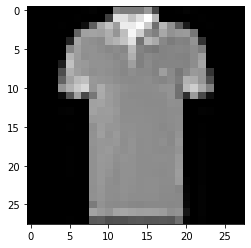


Here's a perturbed sample:



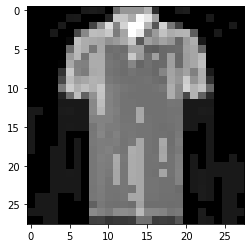


Here's what a 1-steps reconstructed sample looks like:



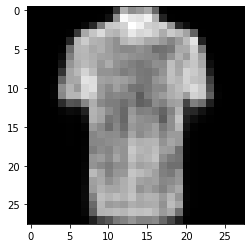


Epsilon: 0.1
Test Accuracy: 40.39%



In [ ]:
final_acc = test_robustness_to_attack(dbn_with_readout,
                                      device,
                                      test_loader,
                                      epsilon=0.1,
                                      num_steps=1)

Let's compare the robustness of each model to adversarial attacks of different "strengths", i.e. different values for the noise parameter $\epsilon$.

In [ ]:
epsilon_values = [0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40]

def test_epsilon_values_effect(model, n_steps):
  accuracies = list()
  for eps in epsilon_values:
      acc = test_robustness_to_attack(model, device, test_loader, eps, num_steps=n_steps, verbose=False)
      accuracies.append(acc)
  return accuracies

In [ ]:
%%capture
accuracies_ffnn  = test_epsilon_values_effect(ffnn, n_steps=0)
accuracies_dbn_0 = test_epsilon_values_effect(dbn_with_readout, n_steps=0) # dbn without reconstruction
accuracies_dbn_1 = test_epsilon_values_effect(dbn_with_readout, n_steps=1) # dbn with reconstruction

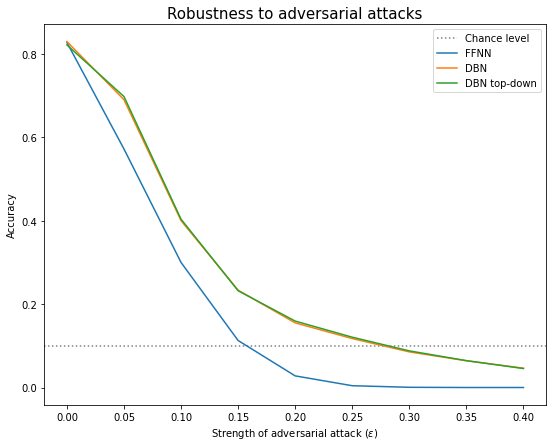

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(9, 7), sharey=True)
ax.axhline(0.1, color='gray', linestyle=':')
ax.plot(epsilon_values, accuracies_ffnn)
ax.plot(epsilon_values, accuracies_dbn_0)
ax.plot(epsilon_values, accuracies_dbn_1)
ax.set_xlabel("Strength of adversarial attack ($\epsilon$)")
ax.set_ylabel("Accuracy")
ax.set_title("Robustness to adversarial attacks", {'fontsize': 15})
ax.legend(["Chance level", "FFNN", "DBN", "DBN top-down"])
plt.show()

---

**Analysis**

We can see that the FFNN shows least resillience against adversarial attacks, while DBN and DBN top-down are more robust. 

By performing one "top-down" reconstruction step, the DBN can reconstruct the input image from its hidden representation in the last layer, effectively removing the adversarial perturbation. This reconstruction step can be seen as a denoising step that reduces the impact of adversarial perturbations on the input image.

---


**Final notes** (about hyperparameter tuning):

Lowering the learning rate of the DBN below 0.1 improved the performance drastically. From there it was about finding the right complexity of the DBN (number of neurons per layer), number of epochs and batch size.
*   Small number of neurons (especially in the first layer) meant that the network wasn’t powerful enough to capture important patterns, and also it encoded patterns from different classes onto a single receptive field.
*   Large number of neurons (especially in the last layer) meant overfitting, which could be observed by repetitive images when visualizing the receptive fields of the last layer. This meant that it was just copying previously learnt knowledge and not trying to build on top of that.